In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import seaborn as sns

In [20]:
Hidro = False

In [21]:
# Parametros de entrada (deben ser modificados dependiendo de los años a analizar)
years = [2020,2021,2022,2023,2024]  # Vector con los años a analizar
last_year_month = 6  # Mes del último año a analizar, si se tiene el año completo utilizar 12

# Parametros fijos
last_day = {'01':31,'02':28,'03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}
Años_bisiestos = [2020,2024,2028,2032,2036,2040,2044,2048,2052,2056,2060]  # Años bisiestos
meses = ['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre','diciembre']  # Vector con los meses del año
months_numbers = {'enero':'01','febrero':'02','marzo':'03','abril':'04','mayo':'05','junio':'06','julio':'07','agosto':'08','septiembre':'09','octubre':'10','noviembre':'11','diciembre':'12'}  # Diccionario que relaciona el nombre del mes con su número
numbers_months = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}  # Diccionario que relaciona el número del mes con su nombre

In [22]:
root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

# Directorios principales
Estudio_Principal_dir = os.path.join(root_dir, 'a. Estudio Principal')
ProcesamientoDatos_dir = os.path.join(Estudio_Principal_dir, 'a. Procesamiento de datos')
Estudios_dir = os.path.join(Estudio_Principal_dir, 'b. Estudios preliminares Sistema')
Simulacion_dir = os.path.join(Estudio_Principal_dir, 'c. Simulacion sistema')

# Datos de entrada
DatosEntrada_dir = os.path.join(root_dir, '1. Datos de entrada')
GenData_dir = os.path.join(DatosEntrada_dir, 'Generacion')
datosCEN_dir = os.path.join(GenData_dir, 'Datos_CEN')
CapacidadInstalda_file = os.path.join(GenData_dir, 'Capacidad_Instalada.xlsx')
df_CapacidadInst = pd.read_excel(CapacidadInstalda_file, sheet_name='Capacidad')  # Se lee el archivo de capacidad instalada

# Datos de generacion procesados
DatosProcesados_dir = os.path.join(ProcesamientoDatos_dir, 'Output')

# Directorios de procesamiento de datos
Figuras_dir = os.path.join(Estudios_dir, 'Figuras')

#Crear las carpetas que no existan
if not os.path.exists(Figuras_dir): os.makedirs(Figuras_dir)

In [23]:
df_CapacidadInst = pd.read_csv(os.path.join(Estudios_dir,'Output','CapacidadInstalada.csv'))

In [24]:
def cargar_dataset(Data_dir):
    df_sol_data = pd.read_parquet(os.path.join(Data_dir, 'df_sol_data.parquet'))
    df_eol_data = pd.read_parquet(os.path.join(Data_dir, 'df_eol_data.parquet'))
    df_hid_data = pd.read_parquet(os.path.join(Data_dir, 'df_hid_data.parquet'))
    df_dem_data = pd.read_parquet(os.path.join(Data_dir, 'df_dem_data.parquet'))
    df_ren_data = pd.read_parquet(os.path.join(Data_dir, 'df_ren_data.parquet'))

    df_PotenciaSistema = pd.read_parquet(os.path.join(Data_dir, 'df_PotenciaSistema.parquet'))

    df_sol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Solar')
    df_eol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Eolica')
    df_hid_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Hidro')
    df_dem_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Demanda')
    df_ren_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='ERNC')

    df_tech_data = [df_sol_data, df_eol_data, df_hid_data, df_dem_data, df_ren_data]
    df_tech_info = [df_sol_info, df_eol_info, df_hid_info, df_dem_info, df_ren_info]

    return df_tech_data, df_tech_info, df_PotenciaSistema

[df_sol_data, df_eol_data, df_hid_data, df_dem_data, df_ren_data], [df_sol_info, df_eol_info, df_hid_info, df_dem_info, df_ren_info], df_PotenciaSistema = cargar_dataset(DatosProcesados_dir)

In [25]:
def Gen_MesDiaHora(df_input,tipo):
    if tipo == "Month":
        array_1 = ['Year','Month']
        array_2 = ['Day','Hour']
    elif tipo == "Day":
        array_1 = ['Year','Month','Day']
        array_2 = ['Hour']
    elif tipo == "Hour":
        array_1 = ['Year','Month','Day','Hour']
        array_2 = []

    df_output = df_input.copy(deep=True)
    df_output = df_output.groupby(array_1).sum().drop(array_2, axis=1).sum(axis=1)
    df_output = df_output
    return df_output

def get_idx_plots(df_hour,df_day,df_month):
    """
    El objetivo de esta funcion es retornar los puntos x para graficar los indicadores en meses dias y horas en un solo grafico
    """
    df_hour = df_hour.reset_index()
    df_day = df_day.reset_index()
    df_month = df_month.reset_index()

    idx_hour = list(range(len(df_hour)))
    idx_day = []
    idx_month = []

    for _,row in df_day.iterrows():
        day = row['Day']
        month = row['Month']
        year = row['Year']
        idx_day.append(df_hour[(df_hour['Day'] == day) & (df_hour['Month'] == month) & (df_hour['Year'] == year)].index[0])

    for _,row in df_month.iterrows():
        month = row['Month']
        year = row['Year']
        idx_month.append(df_hour[(df_hour['Month'] == month) & (df_hour['Year'] == year)].index[0])
    
    return idx_hour,idx_day,idx_month

def Calcular_Indicadores(df_sol, df_eol, df_hid, df_load):
    if Hidro:
        suma_ER_hor = df_sol + df_eol + df_hid
    else:
        suma_ER_hor = df_sol + df_eol
    resta_ER_load_hor = abs(suma_ER_hor - df_load)
    R_hor_porcentaje = resta_ER_load_hor/df_load*100
    R_hor_cambio = 100 - R_hor_porcentaje
    return R_hor_cambio, R_hor_porcentaje

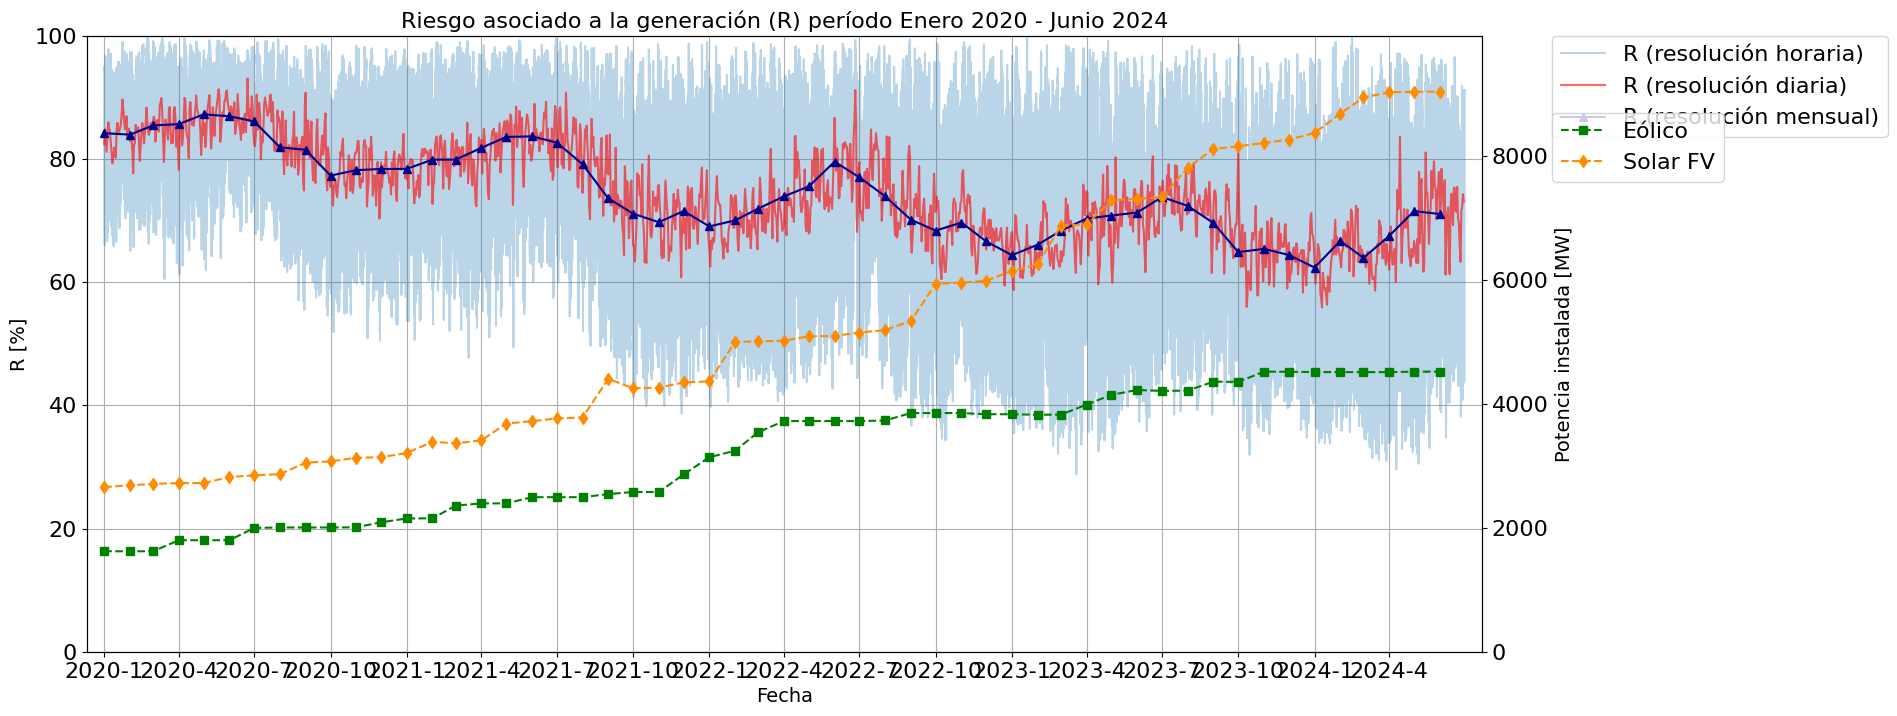

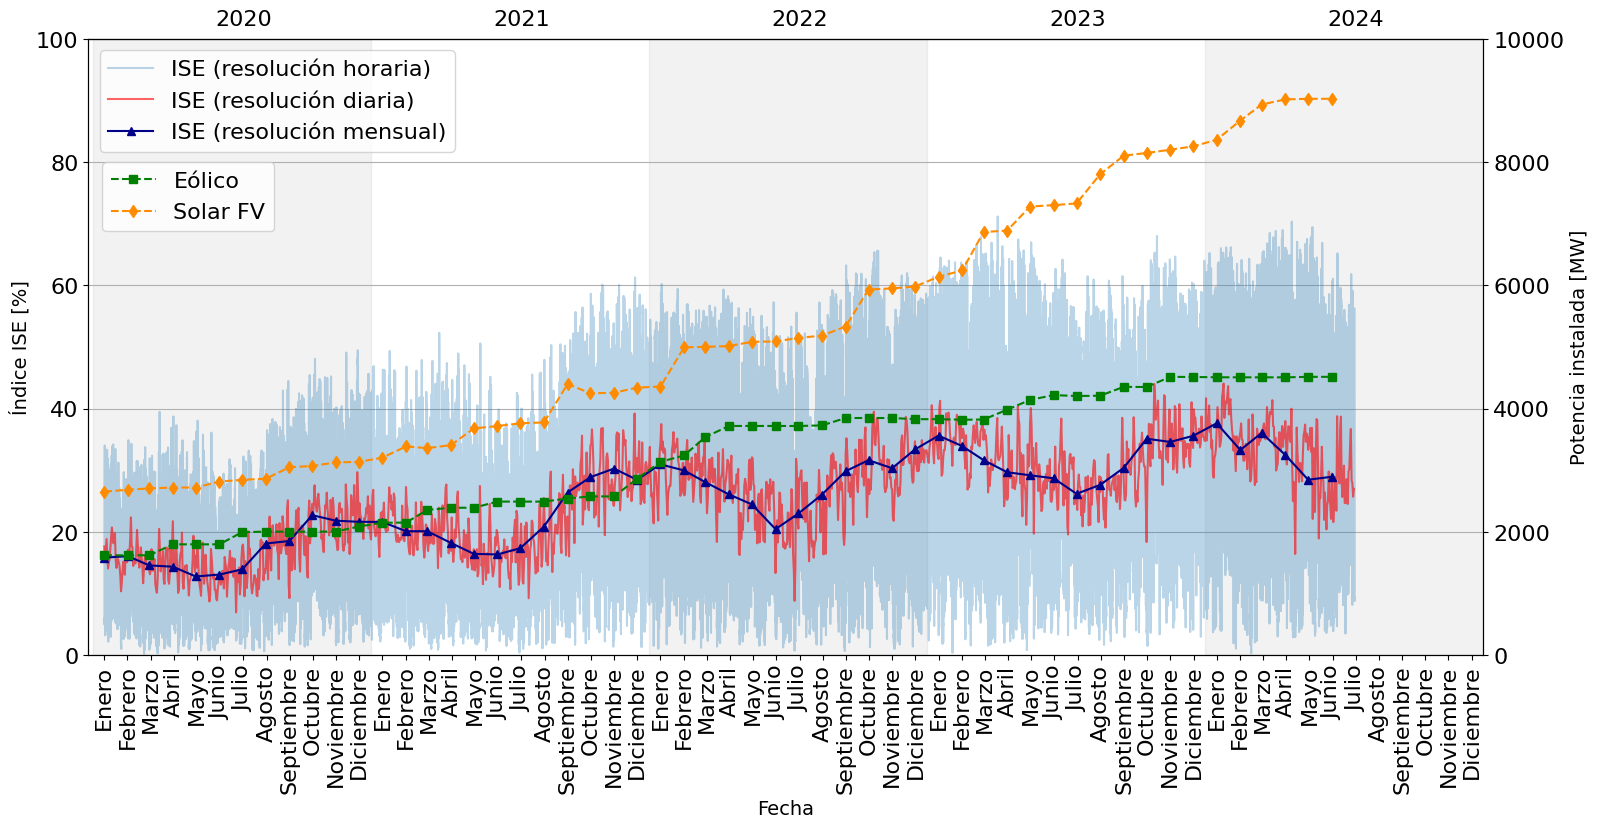

Valores de R (%)
Promedio horario de R 75.13346850599692
Máximo horario de R 99.79633495158163
Mínimo horario de R 28.792011282571274
Desviación estándar horaria de R 17.937202904118546
---
Promedio diario de R 74.46547097470004
Máximo diario de R 93.0606675677243
Mínimo diario de R 55.908887689401695
Desviación estándar diaria de R 7.852105991584764
---
Promedio mensual de R 74.48339148991234
Máximo mensual de R 87.23514953903873
Mínimo mensual de R 62.37005852454458
Desviación estándar mensual de R 6.96842767254354
Valores de ISE (%)
Promedio horario de ISE 24.86653149400309
Máximo horario de ISE 71.20798871742872
Mínimo horario de ISE 0.2036650484183724
Desviación estándar horaria de ISE 17.937202904118546
---
Promedio diario de ISE 25.534529025299957
Máximo diario de ISE 44.091112310598305
Mínimo diario de ISE 6.939332432275705
Desviación estándar diaria de ISE 7.852105991584764
---
Promedio mensual de ISE 25.516608510087664
Máximo mensual de ISE 37.62994147545542
Mínimo mensual de

In [26]:
# Datos con resolucion mensual en formato array
df_sol_mes = Gen_MesDiaHora(df_sol_data,"Month")
df_eol_mes = Gen_MesDiaHora(df_eol_data,"Month")
df_hid_mes = Gen_MesDiaHora(df_hid_data,"Month")
df_load_mes = Gen_MesDiaHora(df_dem_data,"Month")
df_ren_mes = Gen_MesDiaHora(df_ren_data,"Month")

# Datos con resolucion diaria en formato array
df_sol_dia = Gen_MesDiaHora(df_sol_data,"Day")
df_eol_dia = Gen_MesDiaHora(df_eol_data,"Day")
df_hid_dia = Gen_MesDiaHora(df_hid_data,"Day")
df_load_dia = Gen_MesDiaHora(df_dem_data,"Day")
df_ren_dia = Gen_MesDiaHora(df_ren_data,"Day")

# Datos con resolucion horaria en formato array
df_sol_hora = Gen_MesDiaHora(df_sol_data,"Hour")
df_eol_hora = Gen_MesDiaHora(df_eol_data,"Hour")
df_hid_hora = Gen_MesDiaHora(df_hid_data,"Hour")
df_load_hora = Gen_MesDiaHora(df_dem_data,"Hour")
df_ren_hora = Gen_MesDiaHora(df_ren_data,"Hour")

# Calculo indicador horario
R_hor_cambio,R_hor_porcentaje = Calcular_Indicadores(df_sol_hora, df_eol_hora, df_hid_hora, df_load_hora)

# Calculo indicador diario
R_dia_cambio,R_dia_porcentaje = Calcular_Indicadores(df_sol_dia, df_eol_dia, df_hid_dia, df_load_dia)

# Calculo indicador mensual
R_mes_cambio,R_mes_porcentaje = Calcular_Indicadores(df_sol_mes, df_eol_mes, df_hid_mes, df_load_mes)

idx_hour,idx_day,idx_month = get_idx_plots(R_hor_cambio,R_dia_cambio,R_mes_cambio)

size_figures = (18,8)
save_folder = os.path.join(Figuras_dir,'Indicadores_R_ISE')
if not os.path.exists(save_folder): os.makedirs(save_folder)

if not Hidro:
    save_folder = os.path.join(save_folder,'Sin_Hidro')
    if not os.path.exists(save_folder): os.makedirs(save_folder)

# Cambiar tamaño de fuente
plt.rcParams.update({'font.size': 16})

"""
plt.figure(figsize=size_figures)
plt.plot(idx_hour,R_hor_porcentaje,alpha=0.3)
plt.plot(idx_day,R_dia_porcentaje,color='red',alpha=0.6)
plt.plot(idx_month,R_mes_porcentaje,'-^', color='darkblue')
plt.legend(['R (resolución horaria)','R (resolución diaria)','R (resolución mensual)'],loc=3)
plt.grid()
plt.xlabel('Fecha', fontsize='14')
plt.ylabel('R [%]',fontsize=14)
plt.title('Riesgo asociado a la generación (R) período Enero 2020 - Septiembre 2022',fontsize=16)
plt.xticks(idx_month[::3],
           [str(int(df_sol.loc[i,["Year","Month"]].values[0]))+"-"+str(int(df_sol.loc[i,["Year","Month"]].values[1])) for i in idx_month[::3]])
plt.xlim(-500,len(R_hor_porcentaje)+500)
plt.show()

plt.figure(figsize=(18,8))
plt.plot(idx_hour,R_hor_cambio,alpha=0.3)
plt.plot(idx_day,R_dia_cambio,color='red',alpha=0.6)
plt.plot(idx_month,R_mes_cambio,'-^', color='darkblue')
plt.legend(['ISE (resolución horaria)','ISE (resolución diaria)','ISE (resolución mensual)'],loc='upper left')
plt.grid()
plt.xlabel('Fecha', fontsize='14')
plt.ylabel('Participación [%]',fontsize=14)
plt.title('Índice de abastecimiento Solar-Eólico (ISE) período Enero 2020 - Septiembre 2022',fontsize=16)
plt.xticks(idx_month[::3],
           [str(int(df_sol.loc[i,["Year","Month"]].values[0]))+"-"+str(int(df_sol.loc[i,["Year","Month"]].values[1])) for i in idx_month[::3]])
plt.xlim(-500,len(R_hor_porcentaje)+500)
plt.show()
"""

# Potencia declarada en operación para cada tecnología
# recuperar la capacidad instalada de cada tecnologia para los años a analizar y el ultimo mes
idx_last_month = df_CapacidadInst[(df_CapacidadInst['Month'] == last_year_month) & (df_CapacidadInst['Year'] == years[-1])].index[0]+1
df_CapacidadInst_util = df_CapacidadInst[:idx_last_month]
p_inst_eolica = list(df_CapacidadInst_util["Eolica"].values)
p_inst_solar = list(df_CapacidadInst_util["Solar"].values)
if Hidro: p_inst_hid = list(df_CapacidadInst_util["Hidro"].values)

fig, ax1 = plt.subplots(figsize=size_figures)

ax2 = ax1.twinx()

ax1.plot(idx_hour,R_hor_porcentaje,alpha=0.3)
ax1.plot(idx_day,R_dia_porcentaje, color='red',alpha=0.6)
ax1.plot(idx_month,R_mes_porcentaje,'-^', color='darkblue')
ax2.plot(idx_month,p_inst_eolica,'--s', color='green')
ax2.plot(idx_month,p_inst_solar,'--d', color='darkorange')
if Hidro: ax2.plot(idx_month,p_inst_hid,'--o', color='blue')

if Hidro:
    ax2.set_ylim(0,max(p_inst_eolica+p_inst_solar+p_inst_hid)*1.1)
else:
    ax2.set_ylim(0,max(p_inst_eolica+p_inst_solar)*1.1)

ax1.grid()
ax1.set_xlabel('Fecha', fontsize='14')
ax1.set_ylabel('R [%]', fontsize=14)
ax2.set_ylabel('Potencia instalada [MW]', fontsize=14)
ax1.legend(['R (resolución horaria)','R (resolución diaria)','R (resolución mensual)'],bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
ax1.set_ylim(0,100)
if Hidro:
    ax2.legend(['Eólico','Solar FV','Hidro Pasada'],bbox_to_anchor=(1.05, 0.875),loc='upper left', borderaxespad=0.)
else:
    ax2.legend(['Eólico','Solar FV'],bbox_to_anchor=(1.05, 0.875),loc='upper left', borderaxespad=0.)

title = f'Riesgo asociado a la generación (R) período Enero {years[0]} - {numbers_months[last_year_month]} {years[-1]}'
ax1.set_xlim(-500,len(R_hor_porcentaje)+500)
plt.title(title,fontsize=16)
plt.xticks(idx_month[::3],
           [str(int(df_sol_data.loc[i,["Year","Month"]].values[0]))+"-"+str(int(df_sol_data.loc[i,["Year","Month"]].values[1])) for i in idx_month[::3]])
plt.show()
save_fig = os.path.join(save_folder,'R [%].png')
fig.savefig(save_fig, dpi=300, bbox_inches='tight')

fig, ax1 = plt.subplots(figsize=size_figures)

for i in range(1,5+1):
    idx = i-1
    if idx%2==0:
        rango = [idx*8760-(15*24),idx*8760-(15*24)+8760]
        plt.fill_between(rango, 0, 100, color='gray', alpha=0.1)

#for i in range(1,5):
#    plt.vlines(i*8760-(15*24), 0, 100, color='k', linestyle='--', linewidth=1)

ax2 = ax1.twinx()

ax1.plot(idx_hour,R_hor_cambio,alpha=0.3, label='ISE (resolución horaria)')
ax1.plot(idx_day,R_dia_cambio, color='red',alpha=0.6, label='ISE (resolución diaria)')
ax1.plot(idx_month,R_mes_cambio,'-^', color='darkblue', label='ISE (resolución mensual)')
ax2.plot(idx_month,p_inst_eolica,'--s', color='green', label='Eólico')
ax2.plot(idx_month,p_inst_solar,'--d', color='darkorange', label='Solar FV')
if Hidro: ax2.plot(idx_month,p_inst_hid,'--o', color='blue', label='Hidro')

if Hidro:
    ax2.set_ylim(0,max(p_inst_eolica+p_inst_solar+p_inst_hid)*1.1)
else:
    ax2.set_ylim(0,max(p_inst_eolica+p_inst_solar)*1.1)

# grid only for the first axis in y direction
ax1.grid(axis='y')
ax1.set_xlabel('Fecha', fontsize='14')
ax1.set_ylabel('Índice ISE [%]', fontsize=14)
ax2.set_ylabel('Potencia instalada [MW]', fontsize=14)
#ax1.legend(['ISE (resolución horaria)','ISE (resolución diaria)','ISE (resolución mensual)'],bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
ax1.legend(loc='upper left')
ax1.set_ylim(0,100)
ax2.legend(bbox_to_anchor=(0.01, 0.8),loc='upper left', borderaxespad=0.)
if Hidro: 
    title = f'Índice de abastecimiento Solar-Eólico-Hídrico (ISEH) período Enero {years[0]} - {numbers_months[last_year_month]} {years[-1]}'
else:
    title = f'Índice de abastecimiento Solar-Eólico (ISE) período Enero {years[0]} - {numbers_months[last_year_month]} {years[-1]}'

#plt.xticks(idx_month[::3],
#           [str(int(df_sol_data.loc[i,["Year","Month"]].values[0]))+"-"+str(int(df_sol_data.loc[i,["Year","Month"]].values[1])) for i in idx_month[::3]])

n_times = 8760
n_periods = 5

meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']*n_periods

secx = ax1.secondary_xaxis('top')
secx.set_xticks(np.arange(n_times/2, (n_times*n_periods)-(n_times/2)+1, n_times))
secx.set_xticklabels(years)
secx.tick_params(top = False)

ax1.set_xlim(-500,n_times*n_periods-(15*24))
ax1.set_xticks(np.arange(0, n_times*n_periods, 730), meses, rotation=90)
ax2.set_ylim(0,10000)


#plt.title(title,fontsize=22)

plt.show()
save_fig = os.path.join(save_folder,'ISE [%].png')
fig.savefig(save_fig, dpi=300, bbox_inches='tight')

print('='*83)
print('Valores de R (%)')

print('Promedio horario de R', np.mean(R_hor_porcentaje))
print('Máximo horario de R', np.max(R_hor_porcentaje))
print('Mínimo horario de R', np.min(R_hor_porcentaje))
print('Desviación estándar horaria de R', np.std(R_hor_porcentaje))

print('---')

print('Promedio diario de R', np.mean(R_dia_porcentaje))
print('Máximo diario de R', np.max(R_dia_porcentaje))
print('Mínimo diario de R', np.min(R_dia_porcentaje))
print('Desviación estándar diaria de R', np.std(R_dia_porcentaje))

print('---')

print('Promedio mensual de R', np.mean(R_mes_porcentaje))
print('Máximo mensual de R', np.max(R_mes_porcentaje))
print('Mínimo mensual de R', np.min(R_mes_porcentaje))
print('Desviación estándar mensual de R', np.std(R_mes_porcentaje))

print('='*83)
print('Valores de ISE (%)')

print('Promedio horario de ISE', np.mean(R_hor_cambio))
print('Máximo horario de ISE', np.max(R_hor_cambio))
print('Mínimo horario de ISE', np.min(R_hor_cambio))
print('Desviación estándar horaria de ISE', np.std(R_hor_cambio))

print('---')

print('Promedio diario de ISE', np.mean(R_dia_cambio))
print('Máximo diario de ISE', np.max(R_dia_cambio))
print('Mínimo diario de ISE', np.min(R_dia_cambio))
print('Desviación estándar diaria de ISE', np.std(R_dia_cambio))

print('---')

print('Promedio mensual de ISE', np.mean(R_mes_cambio))
print('Máximo mensual de ISE', np.max(R_mes_cambio))
print('Mínimo mensual de ISE', np.min(R_mes_cambio))
print('Desviación estándar mensual de ISE', np.std(R_mes_cambio))

print('='*83)

In [27]:
for i in range(1,5+1):
    idx = i-1
    if idx%2==0:
        rango = [idx*(8760-(15*24)),(8760-(15*24))*idx+8760-(15*24)]
        print(i, rango)

1 [0, 8400]
3 [16800, 25200]
5 [33600, 42000]
